# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

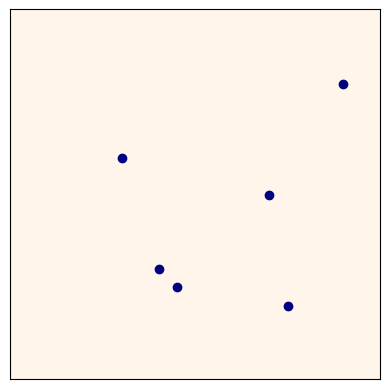

In [2]:
d = 2   # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi*torch.linspace(-.2,1.2,n)
# y = .05*torch.randn((n,d))
# y[:,0] += torch.cos(t)
# y[:,1] += torch.sin(2*t)
# y = .5 + .3*y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n  # loi uniforme sur les points des donnes

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

* Input Layer:

Takes an input of size n_in.

* Hidden Layers:

Consists of nlayers (3 in this case) hidden layers.
Each hidden layer is a fully connected (Linear) layer followed by an Exponential Linear Unit (ELU) activation function with alpha set to 1.
The first hidden layer takes n_in inputs, and subsequent layers take n_hid inputs and produce n_hid outputs.

* Output Layer:

A fully connected (Linear) layer that transforms the n_hid outputs of the last hidden layer to n_out outputs.
Followed by a Sigmoid activation function to ensure the output values are between 0 and 1.

* Weight Initialization:

Weights of the linear layers are initialized using Xavier uniform initialization.
Biases are initialized to zero.

In [3]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1) # alpha =1
        ).to(device))   # For loop for n = nlayers (nlayers = 3) here , so we have 3 hidden layers
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

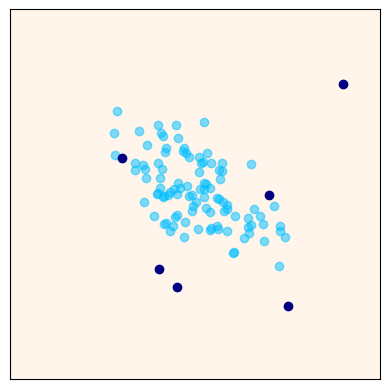

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)


z = torch.randn(b,n_in,device=device)
x = G(z)

### ... ###

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Discriminator Architecture

In [5]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

Adjusting the clip_value during training impacts the discriminator's weight range: a smaller clip_value may cause vanishing gradients, while a larger one can lead to training instability.

[0/1000], -0.007124


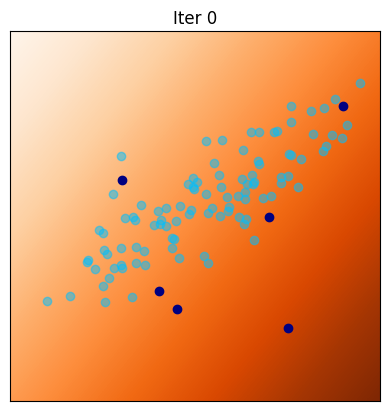

[100/1000], -0.006148


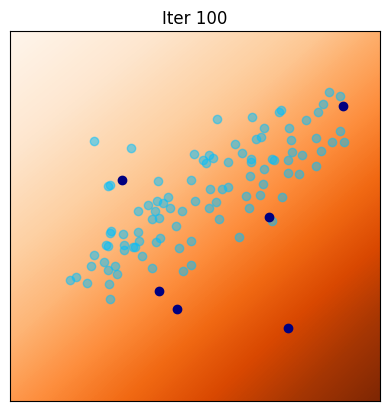

[200/1000], -0.007020


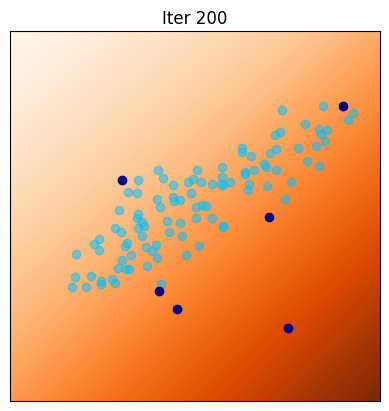

[300/1000], -0.006355


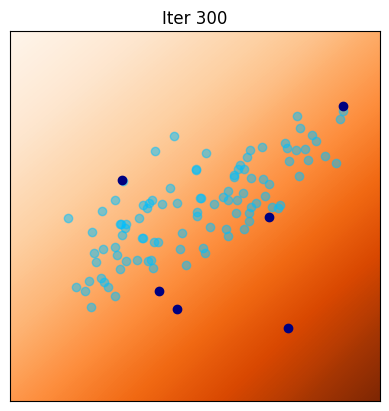

[400/1000], -0.006726


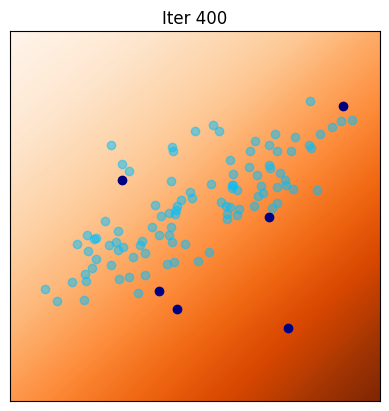

[500/1000], -0.005548


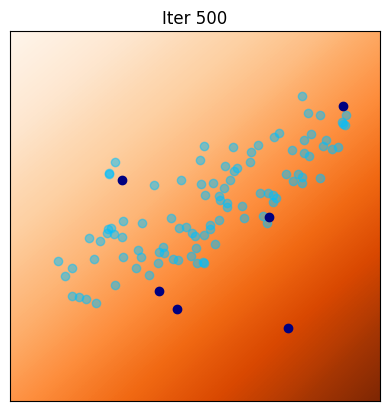

[600/1000], -0.007900


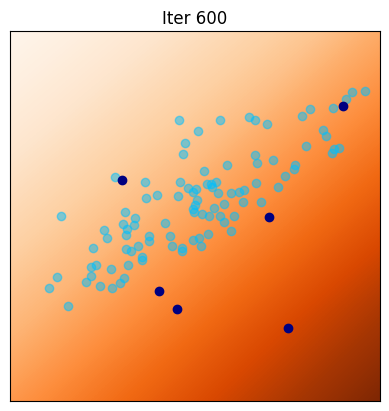

[700/1000], -0.007664


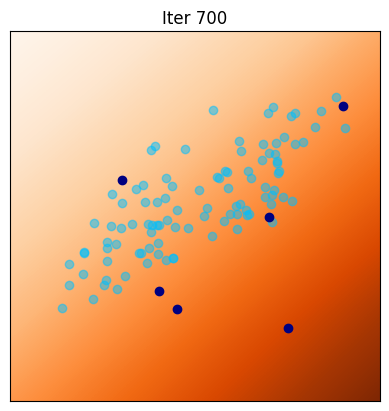

[800/1000], -0.008368


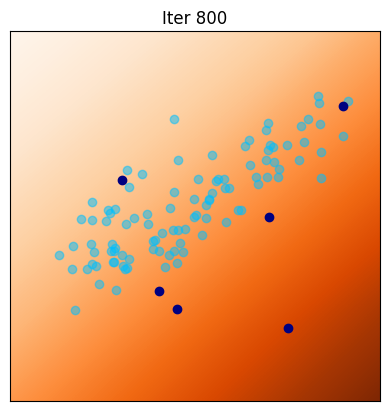

[900/1000], -0.007576


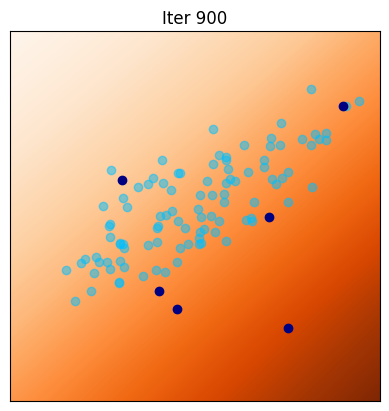

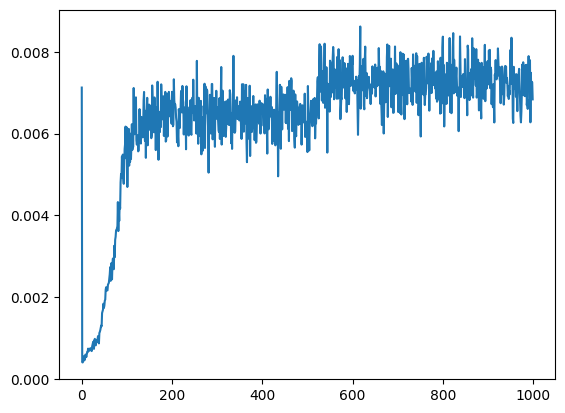

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    ### ... ###
    z = torch.randn(b,n_in)
    x = G(z)
    predict = D.forward(x.detach())

    Dloss = (torch.mean(D.forward(y)) - torch.mean(predict))*-1
    Dloss.backward()
    ### ... ###

    optimD.step()

    ### ... Weight Clipping ... ###
    for p in D.parameters():
      p.data.clamp_(-clip_value,clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [7]:
def lipconstant(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [8]:
print(lipconstant(D,x,y))

tensor(0.0578, grad_fn=<MeanBackward0>)


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [11]:
def gradient_penalty(D,x,y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n>b:
        y = y[0:b,:]
        n = b
    else:
        x = x[0:n,:]
        b = n
    # compute interpolated points
    alpha = torch.rand((b,1),device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()
#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D,x,y))

tensor(0.8878, grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=8.5438, Lip(D)=0.0817


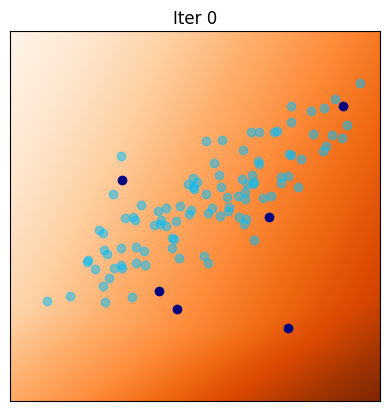

[100/1000], Dloss=0.0388, Lip(D)=1.0040


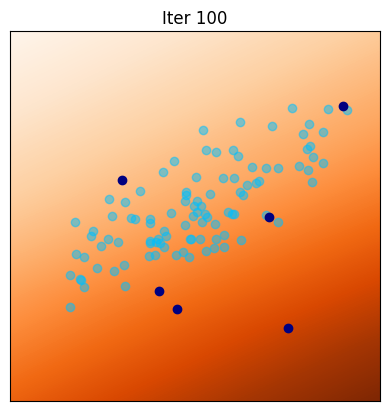

[200/1000], Dloss=-0.0483, Lip(D)=0.9859


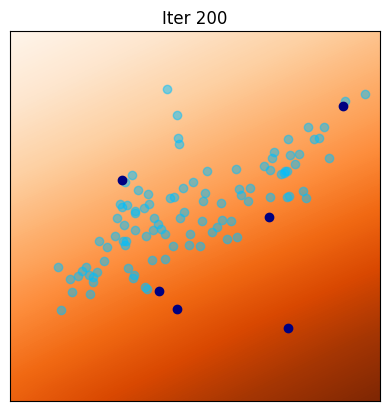

[300/1000], Dloss=-0.0972, Lip(D)=0.9903


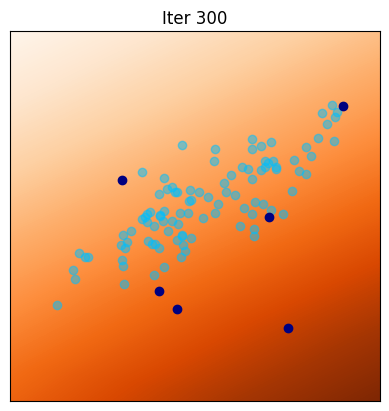

[400/1000], Dloss=-0.0949, Lip(D)=0.9983


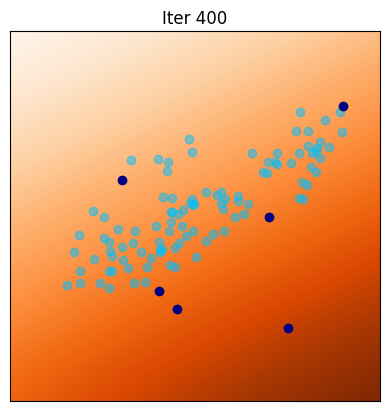

[500/1000], Dloss=-0.1175, Lip(D)=1.0144


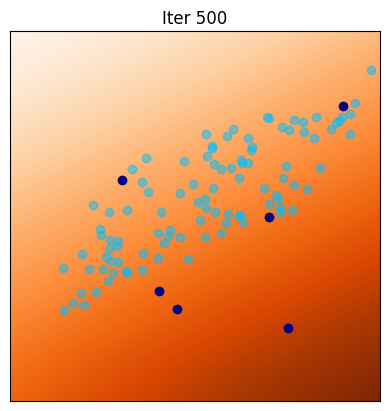

[600/1000], Dloss=-0.1123, Lip(D)=1.0075


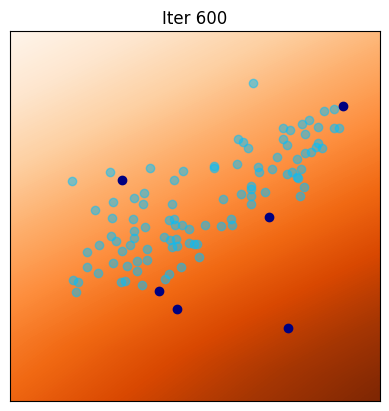

[700/1000], Dloss=-0.1195, Lip(D)=1.0086


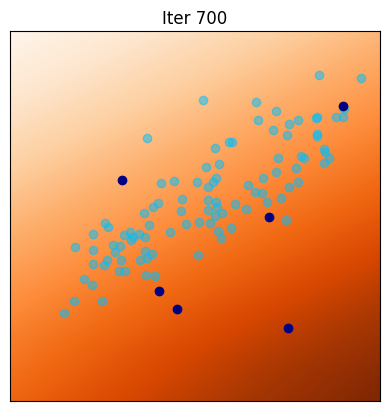

[800/1000], Dloss=-0.1289, Lip(D)=1.0050


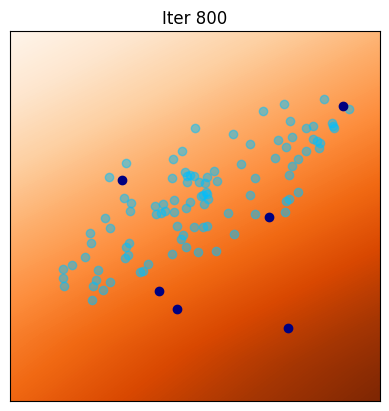

[900/1000], Dloss=-0.1205, Lip(D)=1.0073


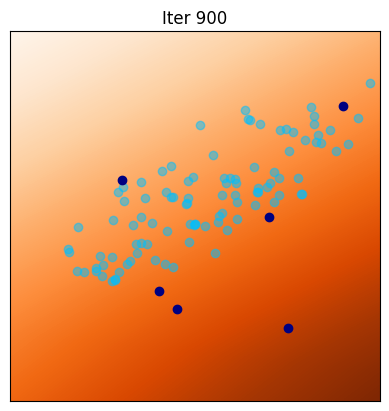

Final estimated Lipschitz constant =  1.0061694383621216


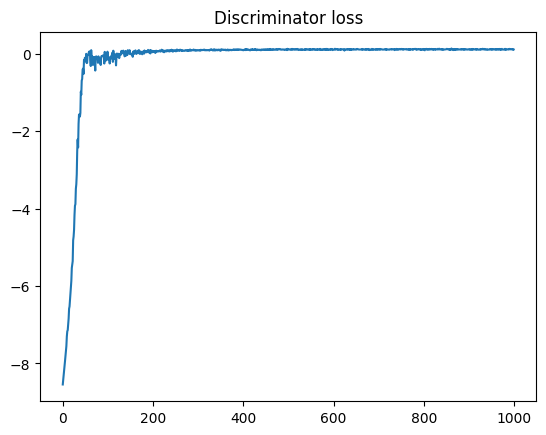

In [14]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000
gpw = 10       # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###

    optimD.zero_grad()

    # Sample real data points
    real_data = y

    # Sample noise and generate fake data points
    z = torch.randn(b, n_in, device=device)
    fake_data = G(z).detach()

    # Compute discriminator loss for real and fake data
    D_real = D(real_data).mean()
    D_fake = D(fake_data).mean()
    Dloss = D_fake - D_real

    # Compute gradient penalty
    gp = gradient_penalty(D, real_data, fake_data)

    # Total loss
    Dloss = Dloss + gpw * gp

    # Update the discriminator
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], Dloss=%.4f, Lip(D)=%.4f' % (iter, niterD, Dlosst,lipconstant(D,x,y).item()))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

[1/100] 	Loss_D: -0.1785	Loss_G: -1.7321	Lip(D)=1.8830
[2/100] 	Loss_D: -0.1476	Loss_G: -1.0235	Lip(D)=1.5365
[3/100] 	Loss_D: -0.1629	Loss_G: -2.1621	Lip(D)=1.7314
[4/100] 	Loss_D: -0.0745	Loss_G: -4.2602	Lip(D)=1.3946
[5/100] 	Loss_D: -0.1133	Loss_G: -9.7450	Lip(D)=1.4555


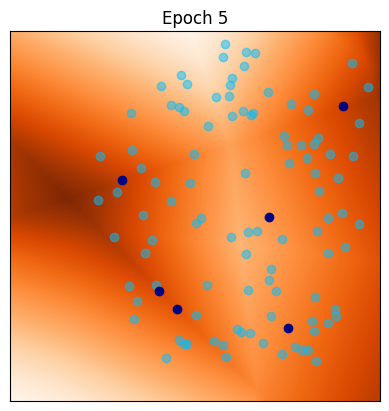

[6/100] 	Loss_D: -0.1652	Loss_G: -12.8220	Lip(D)=1.4792
[7/100] 	Loss_D: -0.2281	Loss_G: -15.2492	Lip(D)=1.8070
[8/100] 	Loss_D: -0.1240	Loss_G: -17.6018	Lip(D)=1.7206
[9/100] 	Loss_D: -0.1081	Loss_G: -17.9721	Lip(D)=1.4325
[10/100] 	Loss_D: -0.0705	Loss_G: -18.9809	Lip(D)=1.3309


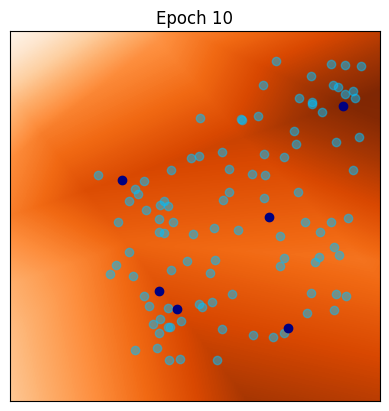

[11/100] 	Loss_D: -0.0518	Loss_G: -21.4081	Lip(D)=1.2640
[12/100] 	Loss_D: -0.1454	Loss_G: -23.0903	Lip(D)=1.3141
[13/100] 	Loss_D: -0.0788	Loss_G: -24.4309	Lip(D)=1.2929
[14/100] 	Loss_D: -0.0959	Loss_G: -24.3829	Lip(D)=1.2990
[15/100] 	Loss_D: -0.0908	Loss_G: -27.7987	Lip(D)=1.1517


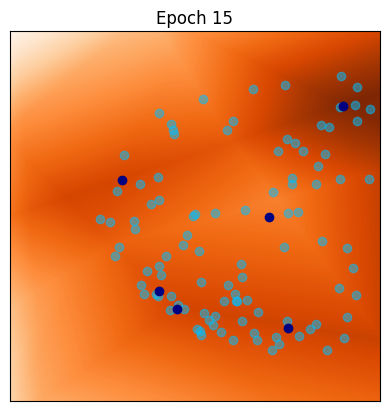

[16/100] 	Loss_D: -0.0706	Loss_G: -30.6539	Lip(D)=1.2149
[17/100] 	Loss_D: -0.0455	Loss_G: -32.6242	Lip(D)=1.2075
[18/100] 	Loss_D: -0.0666	Loss_G: -31.2580	Lip(D)=1.2947
[19/100] 	Loss_D: -0.0974	Loss_G: -35.7117	Lip(D)=1.2049
[20/100] 	Loss_D: -0.0511	Loss_G: -36.3279	Lip(D)=1.0908


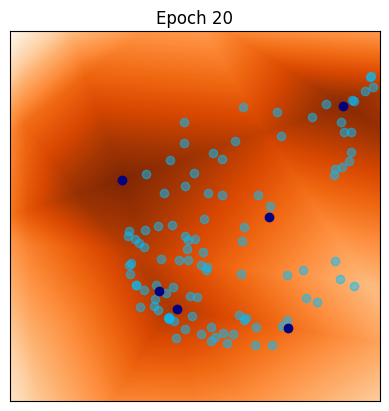

[21/100] 	Loss_D: -0.0745	Loss_G: -36.3278	Lip(D)=1.1502
[22/100] 	Loss_D: -0.0697	Loss_G: -38.5906	Lip(D)=1.3213
[23/100] 	Loss_D: -0.1253	Loss_G: -45.6834	Lip(D)=1.4256
[24/100] 	Loss_D: -0.0795	Loss_G: -46.7077	Lip(D)=1.2694
[25/100] 	Loss_D: -0.0949	Loss_G: -46.2308	Lip(D)=1.1968


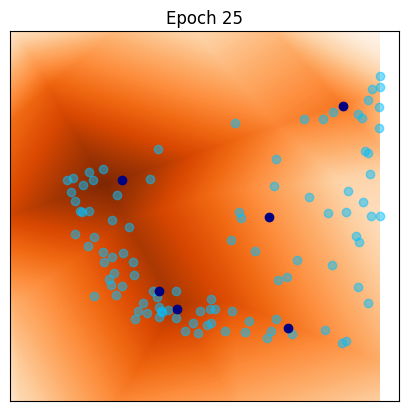

[26/100] 	Loss_D: -0.0977	Loss_G: -51.5115	Lip(D)=1.3158
[27/100] 	Loss_D: -0.1127	Loss_G: -50.7204	Lip(D)=1.3036
[28/100] 	Loss_D: -0.0976	Loss_G: -51.6285	Lip(D)=1.4359
[29/100] 	Loss_D: -0.0958	Loss_G: -53.7237	Lip(D)=1.4178
[30/100] 	Loss_D: -0.1071	Loss_G: -53.6839	Lip(D)=1.2536


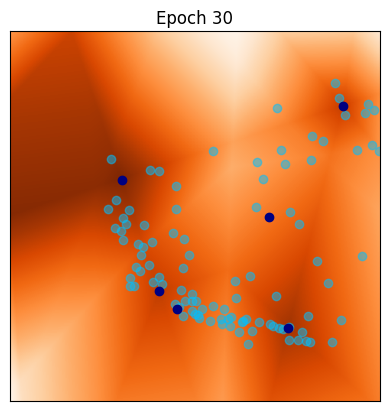

[31/100] 	Loss_D: -0.1024	Loss_G: -54.7948	Lip(D)=1.3461
[32/100] 	Loss_D: -0.1068	Loss_G: -54.8212	Lip(D)=1.1570
[33/100] 	Loss_D: -0.0874	Loss_G: -54.9697	Lip(D)=1.2817
[34/100] 	Loss_D: -0.0695	Loss_G: -55.4447	Lip(D)=1.3388
[35/100] 	Loss_D: -0.1029	Loss_G: -56.4493	Lip(D)=1.1330


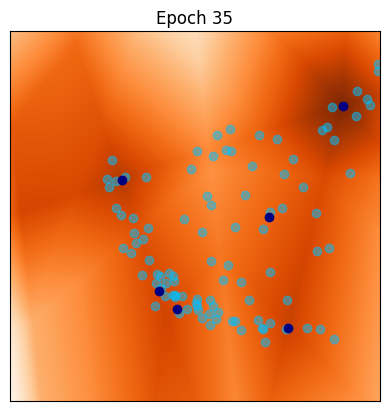

[36/100] 	Loss_D: -0.0816	Loss_G: -56.9550	Lip(D)=1.3439
[37/100] 	Loss_D: -0.0920	Loss_G: -56.1590	Lip(D)=1.3618
[38/100] 	Loss_D: -0.0861	Loss_G: -54.7766	Lip(D)=1.2064
[39/100] 	Loss_D: -0.1000	Loss_G: -52.7992	Lip(D)=1.2378
[40/100] 	Loss_D: -0.1080	Loss_G: -51.6451	Lip(D)=1.2703


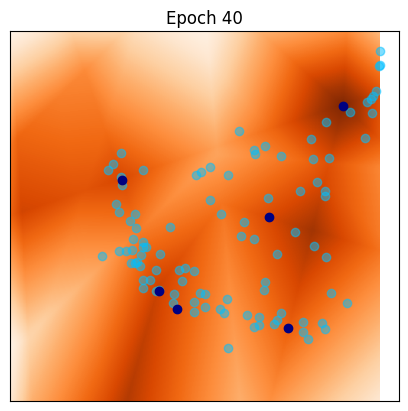

[41/100] 	Loss_D: -0.0879	Loss_G: -52.8327	Lip(D)=1.4882
[42/100] 	Loss_D: -0.1148	Loss_G: -53.6364	Lip(D)=1.2627
[43/100] 	Loss_D: -0.1147	Loss_G: -54.2500	Lip(D)=1.4243
[44/100] 	Loss_D: -0.0950	Loss_G: -55.8476	Lip(D)=1.4823
[45/100] 	Loss_D: -0.0869	Loss_G: -55.4233	Lip(D)=1.2122


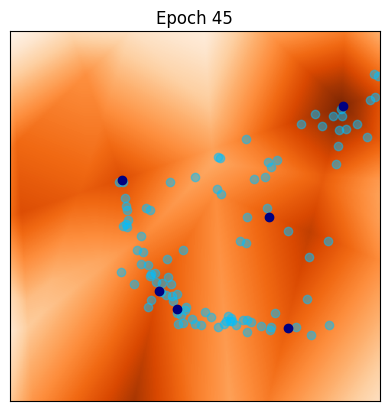

[46/100] 	Loss_D: -0.0721	Loss_G: -55.8813	Lip(D)=1.3811
[47/100] 	Loss_D: -0.0788	Loss_G: -52.2562	Lip(D)=1.2928
[48/100] 	Loss_D: -0.0899	Loss_G: -55.3798	Lip(D)=1.3641
[49/100] 	Loss_D: -0.0982	Loss_G: -58.7280	Lip(D)=1.3278
[50/100] 	Loss_D: -0.0845	Loss_G: -59.7188	Lip(D)=1.3231


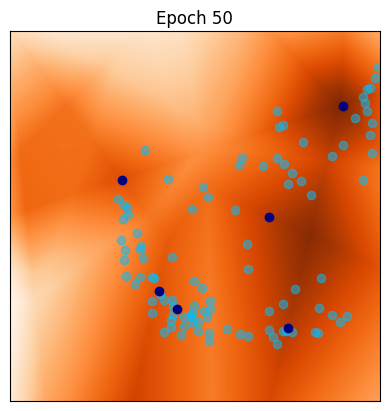

[51/100] 	Loss_D: -0.0872	Loss_G: -59.0753	Lip(D)=1.1684
[52/100] 	Loss_D: -0.0924	Loss_G: -59.0624	Lip(D)=1.2176
[53/100] 	Loss_D: -0.0711	Loss_G: -61.8966	Lip(D)=1.2979
[54/100] 	Loss_D: -0.1007	Loss_G: -61.3659	Lip(D)=1.3001
[55/100] 	Loss_D: -0.0959	Loss_G: -64.1232	Lip(D)=1.2042


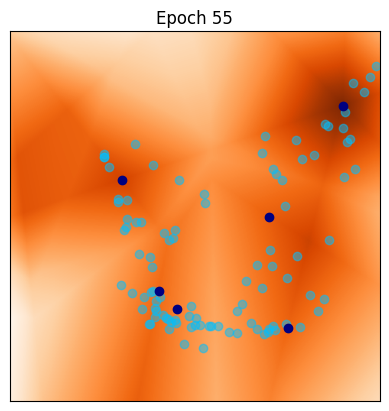

[56/100] 	Loss_D: -0.0632	Loss_G: -65.0505	Lip(D)=1.3333
[57/100] 	Loss_D: -0.0608	Loss_G: -61.9413	Lip(D)=1.1477
[58/100] 	Loss_D: -0.0767	Loss_G: -63.3376	Lip(D)=1.1975
[59/100] 	Loss_D: -0.0645	Loss_G: -68.0576	Lip(D)=1.3404
[60/100] 	Loss_D: -0.0777	Loss_G: -69.4821	Lip(D)=1.3543


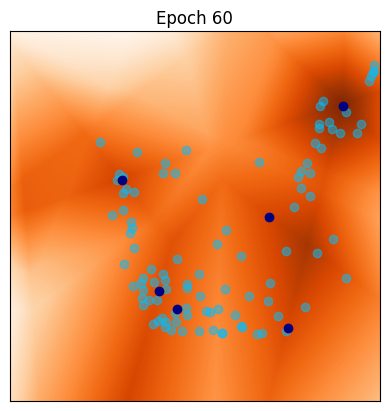

[61/100] 	Loss_D: -0.0860	Loss_G: -69.4301	Lip(D)=1.5030
[62/100] 	Loss_D: -0.1011	Loss_G: -67.7734	Lip(D)=1.4007
[63/100] 	Loss_D: -0.0746	Loss_G: -67.8464	Lip(D)=1.4464
[64/100] 	Loss_D: -0.1095	Loss_G: -77.3031	Lip(D)=1.4360
[65/100] 	Loss_D: -0.0806	Loss_G: -93.1698	Lip(D)=1.5040


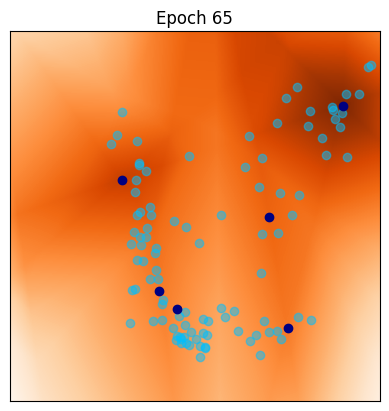

[66/100] 	Loss_D: -0.0975	Loss_G: -97.9847	Lip(D)=0.9349
[67/100] 	Loss_D: -0.1271	Loss_G: -91.6053	Lip(D)=1.3303
[68/100] 	Loss_D: -0.0421	Loss_G: -96.0375	Lip(D)=1.4583
[69/100] 	Loss_D: -0.0798	Loss_G: -103.7859	Lip(D)=1.2574
[70/100] 	Loss_D: -0.0901	Loss_G: -107.8885	Lip(D)=1.1549


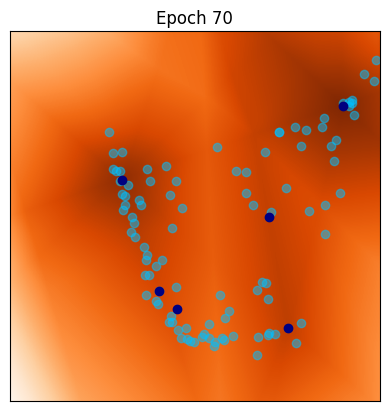

[71/100] 	Loss_D: -0.0619	Loss_G: -110.9068	Lip(D)=1.1695
[72/100] 	Loss_D: -0.1034	Loss_G: -109.9271	Lip(D)=1.3397
[73/100] 	Loss_D: -0.0770	Loss_G: -111.3006	Lip(D)=1.2775
[74/100] 	Loss_D: -0.0773	Loss_G: -115.4011	Lip(D)=1.2343
[75/100] 	Loss_D: -0.0740	Loss_G: -116.7615	Lip(D)=1.1946


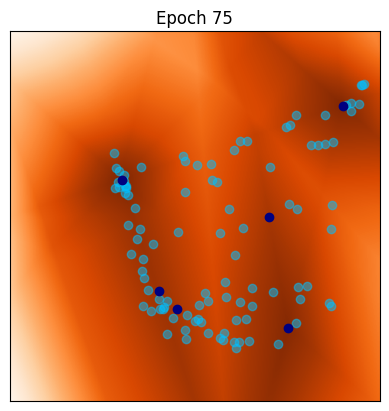

[76/100] 	Loss_D: -0.0919	Loss_G: -114.4921	Lip(D)=1.3463
[77/100] 	Loss_D: -0.0823	Loss_G: -121.1562	Lip(D)=1.3242
[78/100] 	Loss_D: -0.0739	Loss_G: -118.1037	Lip(D)=1.2032
[79/100] 	Loss_D: -0.0803	Loss_G: -117.6440	Lip(D)=1.3101
[80/100] 	Loss_D: -0.0623	Loss_G: -114.8866	Lip(D)=1.2686


[81/100] 	Loss_D: -0.0859	Loss_G: -119.0785	Lip(D)=1.2212
[82/100] 	Loss_D: -0.0563	Loss_G: -114.9069	Lip(D)=1.2068
[83/100] 	Loss_D: -0.0846	Loss_G: -117.8539	Lip(D)=1.0414
[84/100] 	Loss_D: -0.0860	Loss_G: -116.4595	Lip(D)=1.3029
[85/100] 	Loss_D: -0.0631	Loss_G: -114.2417	Lip(D)=1.2645


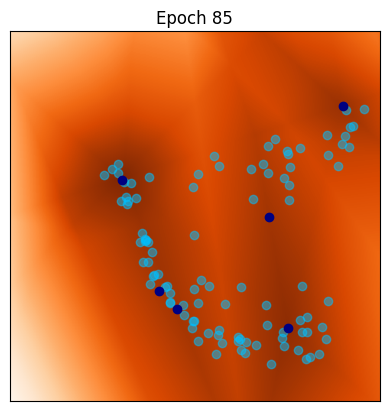

[86/100] 	Loss_D: -0.0319	Loss_G: -123.6672	Lip(D)=1.2337
[87/100] 	Loss_D: -0.0571	Loss_G: -120.9588	Lip(D)=1.1328
[88/100] 	Loss_D: -0.0703	Loss_G: -112.0409	Lip(D)=1.1676
[89/100] 	Loss_D: -0.1053	Loss_G: -119.3158	Lip(D)=1.1516
[90/100] 	Loss_D: -0.0755	Loss_G: -122.7460	Lip(D)=1.0652


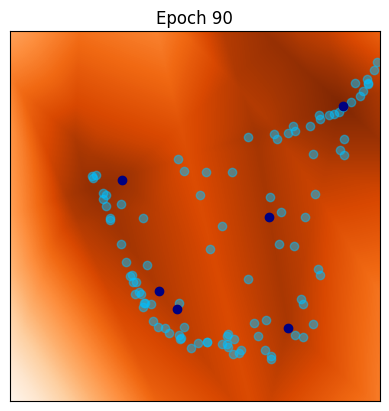

[91/100] 	Loss_D: -0.0480	Loss_G: -100.4126	Lip(D)=1.2599
[92/100] 	Loss_D: -0.0919	Loss_G: -107.6175	Lip(D)=1.5134
[93/100] 	Loss_D: -0.0645	Loss_G: -106.1357	Lip(D)=1.2199
[94/100] 	Loss_D: -0.0934	Loss_G: -106.5479	Lip(D)=1.4860
[95/100] 	Loss_D: -0.0890	Loss_G: -113.8087	Lip(D)=1.4554


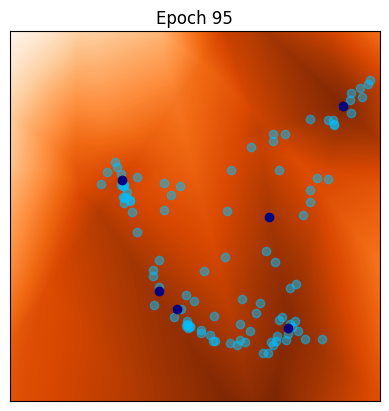

[96/100] 	Loss_D: -0.0406	Loss_G: -106.6379	Lip(D)=1.3587
[97/100] 	Loss_D: -0.0843	Loss_G: -108.6998	Lip(D)=1.1558
[98/100] 	Loss_D: -0.0352	Loss_G: -106.1571	Lip(D)=1.4147
[99/100] 	Loss_D: -0.0703	Loss_G: -103.1258	Lip(D)=1.2761


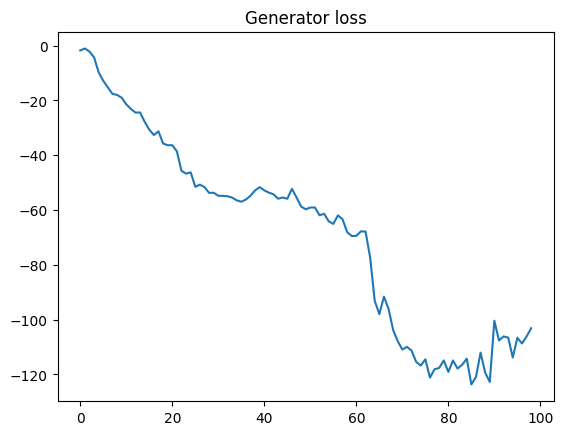

<All keys matched successfully>

In [15]:
## parameters for training
n_epochs = 100
niterD=1000
niterG=10
gpw = .1

lr = 0.002      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        # Sample real data points
        real_data = y

        # Sample noise and generate fake data points
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z).detach()

        # Compute discriminator loss for real and fake data
        D_real = D(real_data).mean()
        D_fake = D(fake_data).mean()
        Dloss = D_fake - D_real

        # Compute gradient penalty
        gp = gradient_penalty(D, real_data, fake_data)

        # Total loss
        Dloss = Dloss + gpw * gp

        # Update the discriminator
        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        # Sample noise and generate fake data points
        z = torch.randn(b, n_in, device=device)
        fake_data = G(z)

        # Compute generator loss
        Gloss = -D(fake_data).mean()

        # Update the generator
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lipconstant(D,x,y).item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

For stable GAN training, we can use lower learning rates for the generator than the discriminator, and  tune the gradient penalty weight.

[1/30] 	Loss_D: 0.5618	Loss_G: -0.4656	Lip(D)=0.9545
[2/30] 	Loss_D: 0.1108	Loss_G: -0.6414	Lip(D)=0.9987
[3/30] 	Loss_D: 0.0045	Loss_G: -0.8110	Lip(D)=1.0177
[4/30] 	Loss_D: 0.0042	Loss_G: -0.9364	Lip(D)=0.9760
[5/30] 	Loss_D: 0.0176	Loss_G: -1.1169	Lip(D)=0.9878


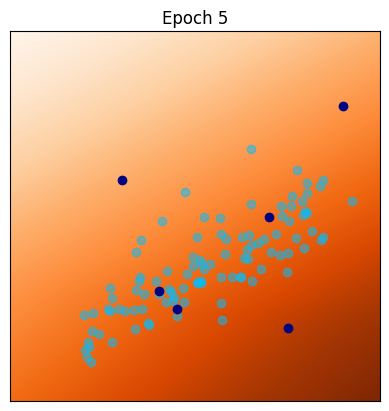

[6/30] 	Loss_D: 0.0262	Loss_G: -1.3182	Lip(D)=0.9850
[7/30] 	Loss_D: 0.1308	Loss_G: -1.5022	Lip(D)=0.9914
[8/30] 	Loss_D: 0.1295	Loss_G: -1.7120	Lip(D)=0.9818
[9/30] 	Loss_D: 0.1899	Loss_G: -2.2060	Lip(D)=0.9849
[10/30] 	Loss_D: 0.1917	Loss_G: -2.4177	Lip(D)=1.0057


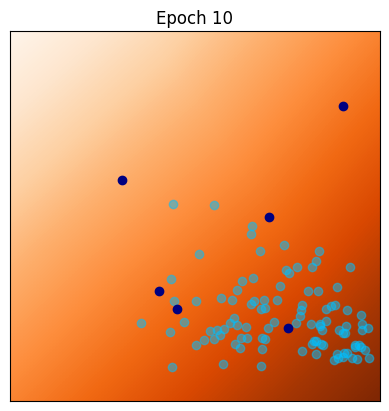

[11/30] 	Loss_D: 0.2876	Loss_G: -2.6557	Lip(D)=0.9959
[12/30] 	Loss_D: 0.3199	Loss_G: -2.8128	Lip(D)=0.9924
[13/30] 	Loss_D: 0.2941	Loss_G: -3.0411	Lip(D)=0.9941
[14/30] 	Loss_D: 0.0033	Loss_G: -3.0406	Lip(D)=1.0214
[15/30] 	Loss_D: -0.3995	Loss_G: -2.7912	Lip(D)=1.0122


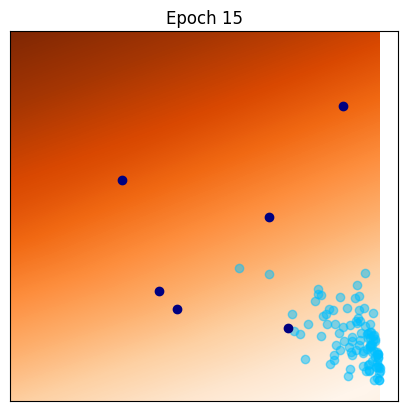

[16/30] 	Loss_D: -0.4327	Loss_G: -2.8691	Lip(D)=1.0075
[17/30] 	Loss_D: -0.3825	Loss_G: -3.0175	Lip(D)=1.0063
[18/30] 	Loss_D: -0.3776	Loss_G: -3.1446	Lip(D)=1.0123
[19/30] 	Loss_D: -0.3179	Loss_G: -3.3168	Lip(D)=1.0067
[20/30] 	Loss_D: -0.2726	Loss_G: -3.4755	Lip(D)=1.0045


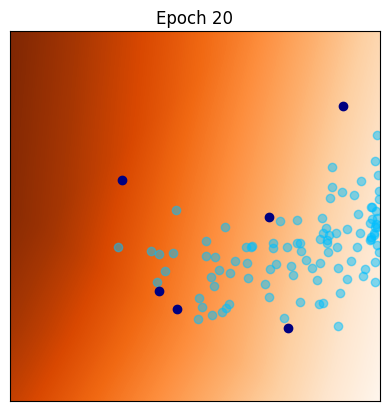

[21/30] 	Loss_D: -0.2370	Loss_G: -3.6347	Lip(D)=1.0056
[22/30] 	Loss_D: -0.1490	Loss_G: -3.7615	Lip(D)=1.0022
[23/30] 	Loss_D: -0.1380	Loss_G: -3.8809	Lip(D)=1.0041
[24/30] 	Loss_D: -0.0996	Loss_G: -4.0197	Lip(D)=1.0012
[25/30] 	Loss_D: -0.0345	Loss_G: -4.1491	Lip(D)=0.9918


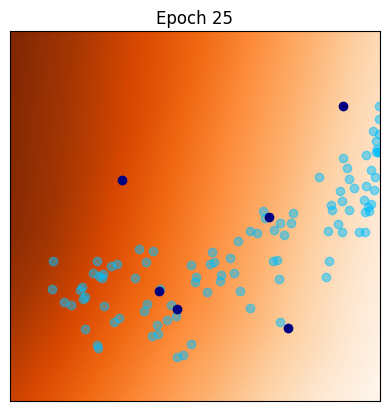

[26/30] 	Loss_D: -0.0455	Loss_G: -4.2940	Lip(D)=1.0015
[27/30] 	Loss_D: -0.0169	Loss_G: -4.4008	Lip(D)=0.9938
[28/30] 	Loss_D: 0.0188	Loss_G: -4.5134	Lip(D)=1.0019
[29/30] 	Loss_D: 0.0842	Loss_G: -4.6544	Lip(D)=0.9972


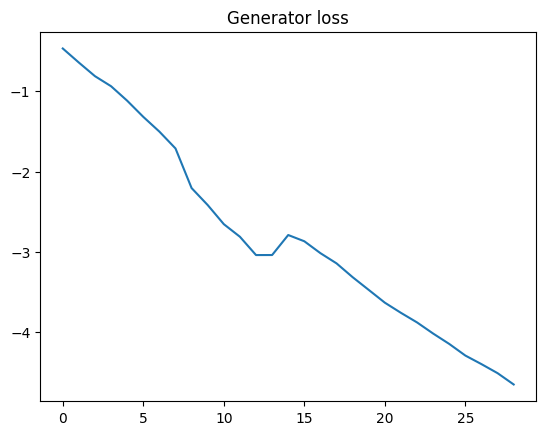

<All keys matched successfully>

In [20]:
## parameters for training
n_epochs = 30
# niterD=1000
# niterG=10
# gpw = 20

# lr = 0.0005      # learning rate for generator
# lrdisc = 0.005  # learning rate for discriminator
# beta_1 = 0.5
# beta_2 = 0.999


lr = 0.001      # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
gpw = 25
niterD = 100
niterG = 10
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################

    for iter in range(0,niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        y_real = y

        D_real = D(y_real).view(-1)
        D_fake = D(x_fake.detach()).view(-1)

        gp = gradient_penalty(D, y_real, x_fake)
        Dloss = -torch.mean(D_real) + torch.mean(D_fake) + gpw * gp

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = -torch.mean(D(x_fake))

        Gloss.backward()
        optimG.step()
    lip_const = lipconstant(D, y, G(torch.randn(b, n_in, device=device)))

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item(),lip_const.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

When we train the generator with a fixed discriminator, the generator learns to produce data that maximizes the fixed discriminator's output. However, since the discriminator's weights are not updated, the generator may overfit to the discriminator's specific weaknesses, potentially leading to poor generalization and less realistic generated data.



[1/100] 	Loss_G: -0.0698
[2/100] 	Loss_G: -0.0760
[3/100] 	Loss_G: -0.0822
[4/100] 	Loss_G: -0.0914
[5/100] 	Loss_G: -0.1019


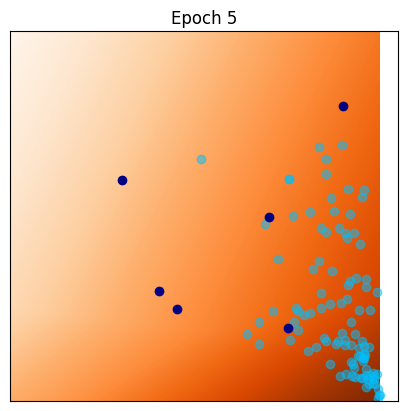

[6/100] 	Loss_G: -0.1119
[7/100] 	Loss_G: -0.1204
[8/100] 	Loss_G: -0.1252
[9/100] 	Loss_G: -0.1278
[10/100] 	Loss_G: -0.1299


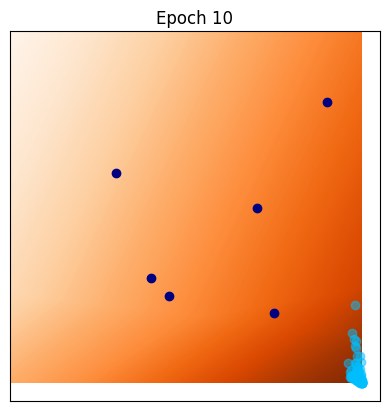

[11/100] 	Loss_G: -0.1305
[12/100] 	Loss_G: -0.1310
[13/100] 	Loss_G: -0.1316
[14/100] 	Loss_G: -0.1318
[15/100] 	Loss_G: -0.1319


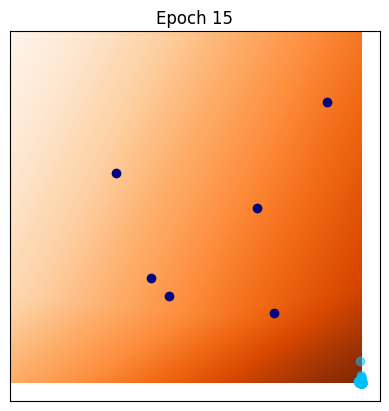

[16/100] 	Loss_G: -0.1321
[17/100] 	Loss_G: -0.1322
[18/100] 	Loss_G: -0.1322
[19/100] 	Loss_G: -0.1323
[20/100] 	Loss_G: -0.1323


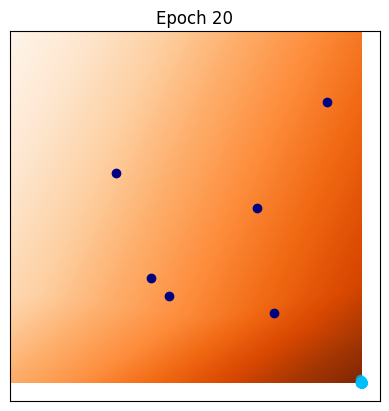

[21/100] 	Loss_G: -0.1324
[22/100] 	Loss_G: -0.1324
[23/100] 	Loss_G: -0.1324
[24/100] 	Loss_G: -0.1325
[25/100] 	Loss_G: -0.1325


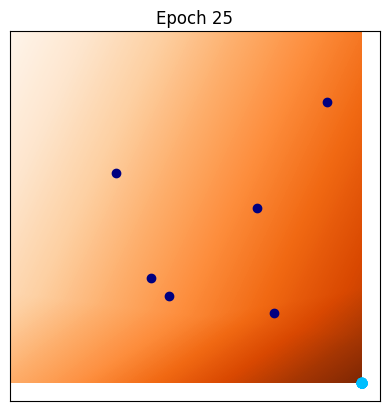

[26/100] 	Loss_G: -0.1325
[27/100] 	Loss_G: -0.1326
[28/100] 	Loss_G: -0.1326
[29/100] 	Loss_G: -0.1326
[30/100] 	Loss_G: -0.1326


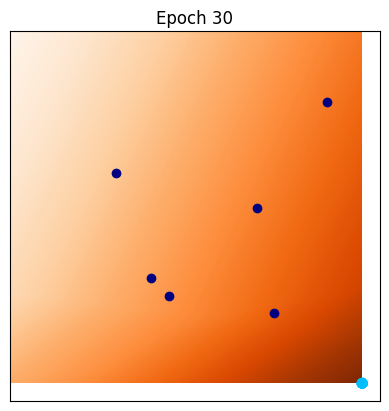

[31/100] 	Loss_G: -0.1326
[32/100] 	Loss_G: -0.1326
[33/100] 	Loss_G: -0.1326
[34/100] 	Loss_G: -0.1326
[35/100] 	Loss_G: -0.1326


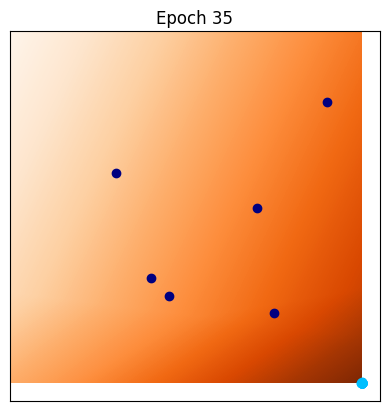

[36/100] 	Loss_G: -0.1326
[37/100] 	Loss_G: -0.1326
[38/100] 	Loss_G: -0.1326
[39/100] 	Loss_G: -0.1326
[40/100] 	Loss_G: -0.1327


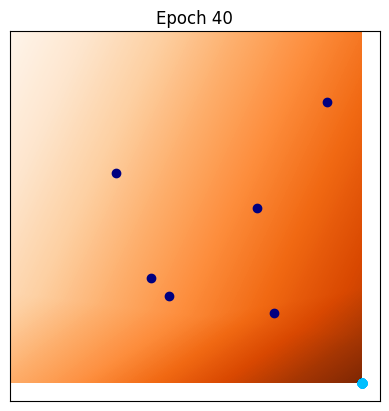

[41/100] 	Loss_G: -0.1326
[42/100] 	Loss_G: -0.1326
[43/100] 	Loss_G: -0.1327
[44/100] 	Loss_G: -0.1327
[45/100] 	Loss_G: -0.1327


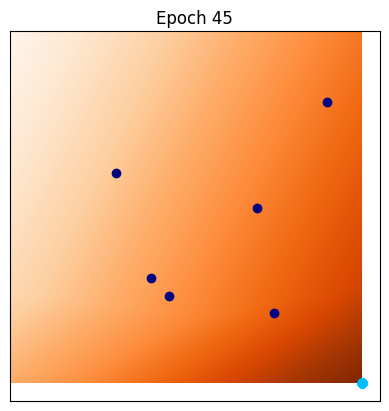

[46/100] 	Loss_G: -0.1327
[47/100] 	Loss_G: -0.1327
[48/100] 	Loss_G: -0.1327
[49/100] 	Loss_G: -0.1327
[50/100] 	Loss_G: -0.1327


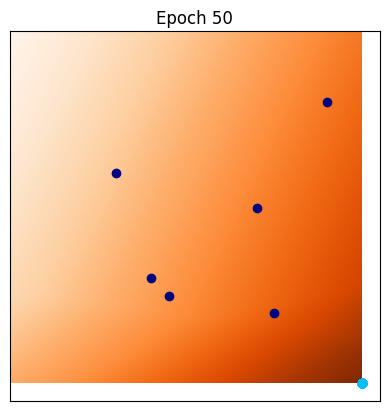

[51/100] 	Loss_G: -0.1327
[52/100] 	Loss_G: -0.1327
[53/100] 	Loss_G: -0.1327
[54/100] 	Loss_G: -0.1327
[55/100] 	Loss_G: -0.1327


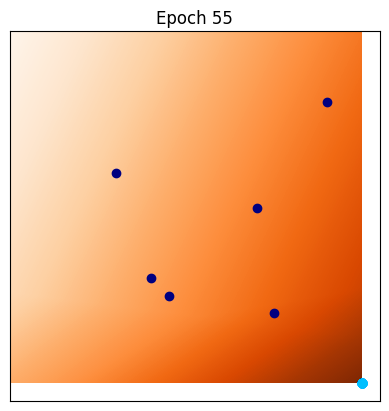

[56/100] 	Loss_G: -0.1327
[57/100] 	Loss_G: -0.1327
[58/100] 	Loss_G: -0.1327
[59/100] 	Loss_G: -0.1327
[60/100] 	Loss_G: -0.1327


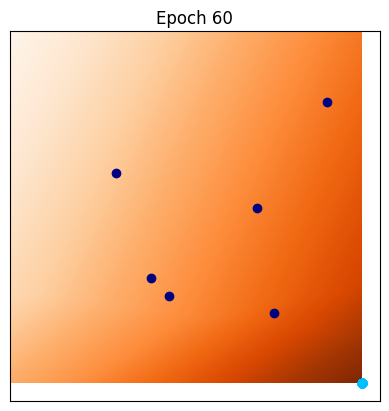

[61/100] 	Loss_G: -0.1327
[62/100] 	Loss_G: -0.1327
[63/100] 	Loss_G: -0.1327
[64/100] 	Loss_G: -0.1327
[65/100] 	Loss_G: -0.1327


[66/100] 	Loss_G: -0.1327
[67/100] 	Loss_G: -0.1327
[68/100] 	Loss_G: -0.1327
[69/100] 	Loss_G: -0.1327
[70/100] 	Loss_G: -0.1327


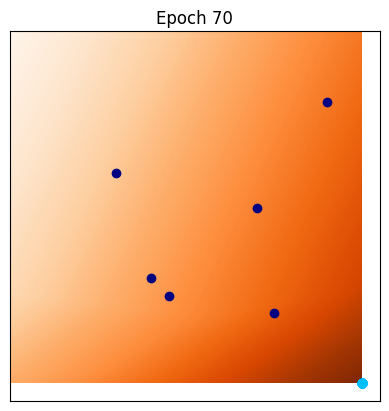

[71/100] 	Loss_G: -0.1327
[72/100] 	Loss_G: -0.1327
[73/100] 	Loss_G: -0.1327
[74/100] 	Loss_G: -0.1327
[75/100] 	Loss_G: -0.1327


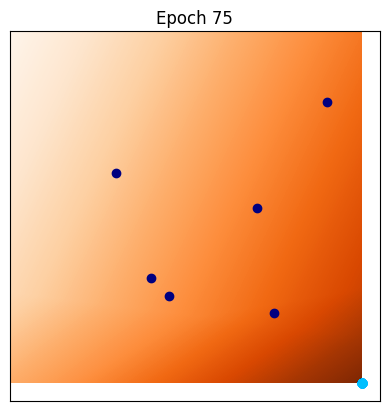

[76/100] 	Loss_G: -0.1327
[77/100] 	Loss_G: -0.1327
[78/100] 	Loss_G: -0.1327
[79/100] 	Loss_G: -0.1327
[80/100] 	Loss_G: -0.1327


[81/100] 	Loss_G: -0.1327
[82/100] 	Loss_G: -0.1327
[83/100] 	Loss_G: -0.1327
[84/100] 	Loss_G: -0.1327
[85/100] 	Loss_G: -0.1327


[86/100] 	Loss_G: -0.1327
[87/100] 	Loss_G: -0.1327
[88/100] 	Loss_G: -0.1327
[89/100] 	Loss_G: -0.1327
[90/100] 	Loss_G: -0.1327


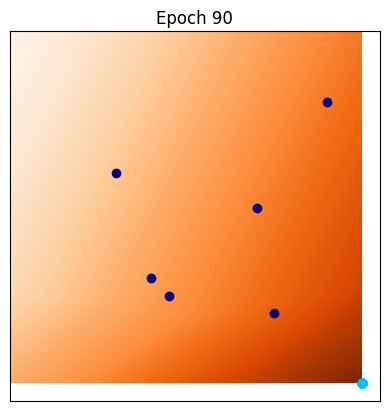

[91/100] 	Loss_G: -0.1327
[92/100] 	Loss_G: -0.1327
[93/100] 	Loss_G: -0.1327
[94/100] 	Loss_G: -0.1327
[95/100] 	Loss_G: -0.1327


[96/100] 	Loss_G: -0.1327
[97/100] 	Loss_G: -0.1327
[98/100] 	Loss_G: -0.1327
[99/100] 	Loss_G: -0.1327
[100/100] 	Loss_G: -0.1327


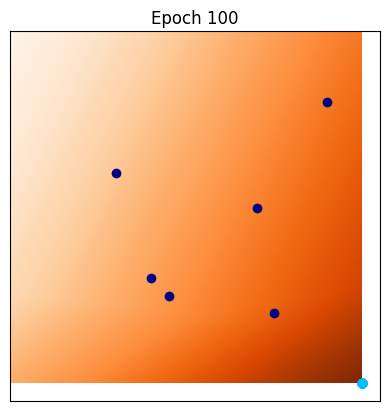

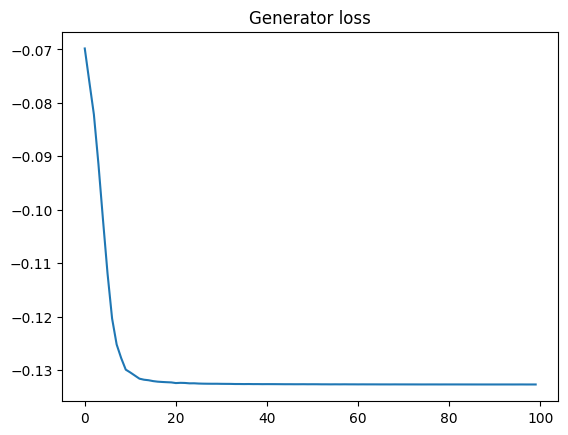

<All keys matched successfully>

In [22]:
# Parameters for training
n_epochs = 100
niterG = 10
gpw = .1

lr = 0.002
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)

G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

D = Discriminator(n_in=d, n_hid=10).to(device)


Glosses = []

iter_display = 5

# Main loop
for epoch in range(1, n_epochs + 1):

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = -torch.mean(D(x_fake))

        Gloss.backward()
        optimG.step()

    print('[%d/%d] \tLoss_G: %.4f'
          % (epoch, n_epochs, Gloss.item()))
    Glosses.append(Gloss.item())

    if epoch % iter_display == 0:
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch ' + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()

wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())


<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [24]:
criterion = nn.BCEWithLogitsLoss()
V1 = torch.full((n,1), 1. , dtype=torch.float, device=device)
V0 = torch.full((b,1), 0. , dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.383946


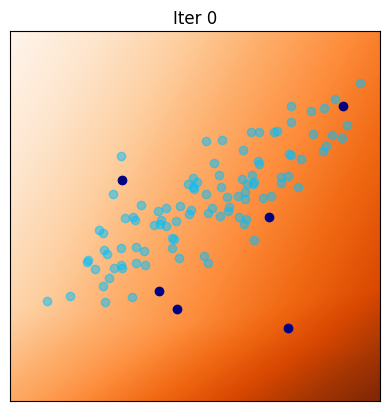

[100/1000], 1.208848


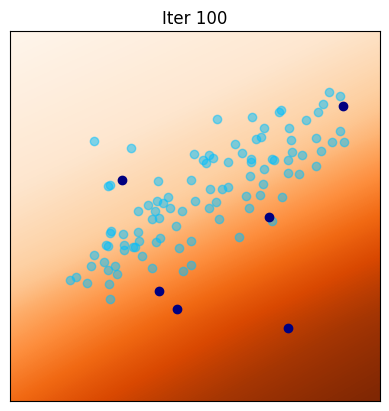

[200/1000], 1.064496


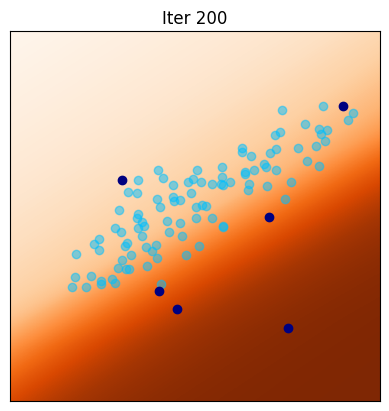

[300/1000], 1.016988


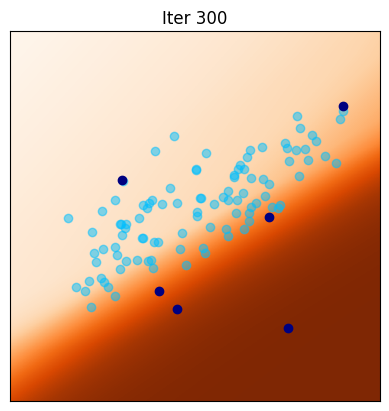

[400/1000], 0.907898


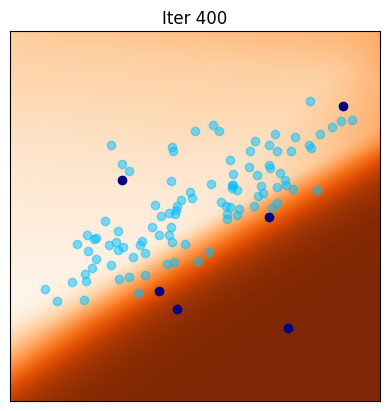

[500/1000], 0.870148


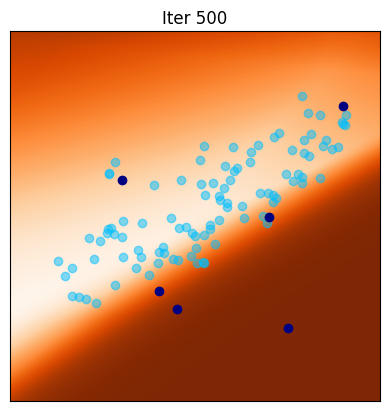

[600/1000], 0.690487


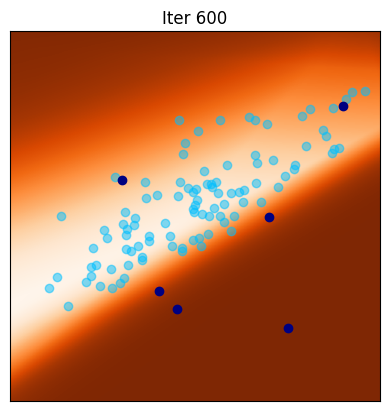

[700/1000], 0.660583


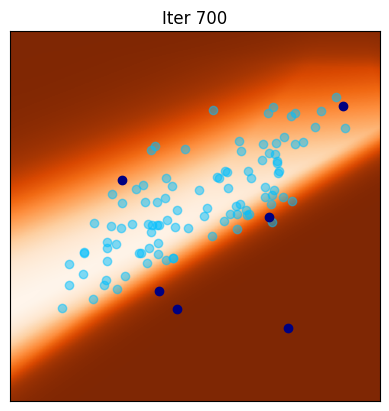

[800/1000], 0.548540


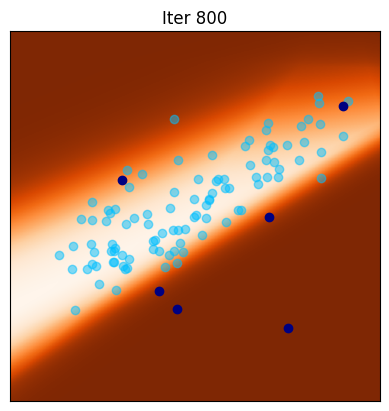

[900/1000], 0.550668


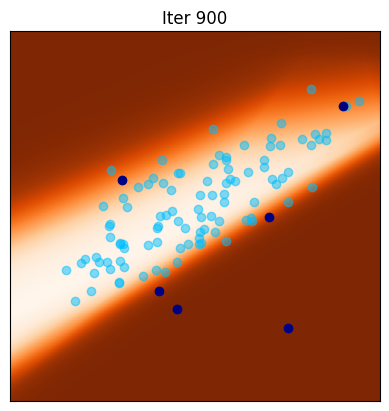

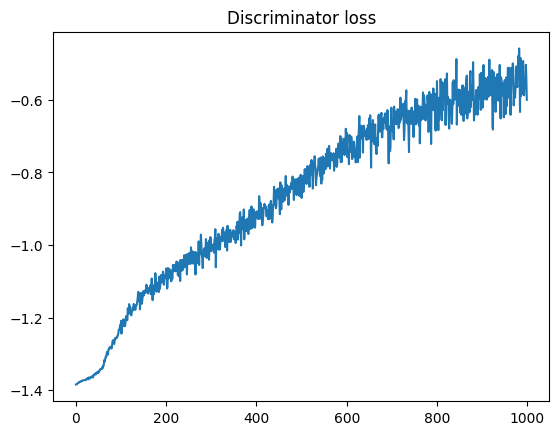

In [25]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    # Sample real data points
    D_real = D(y)
    real_loss = criterion(D_real, V1)

    # Sample noise and generate fake data points
    z = torch.randn(b, n_in, device=device)
    x_fake = G(z)
    D_fake = D(x_fake.detach())
    fake_loss = criterion(D_fake, V0)

    # Total discriminator loss
    Dloss = real_loss + fake_loss

    Dloss.backward()
    optimD.step()


    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.2335	Loss_G: 0.8061


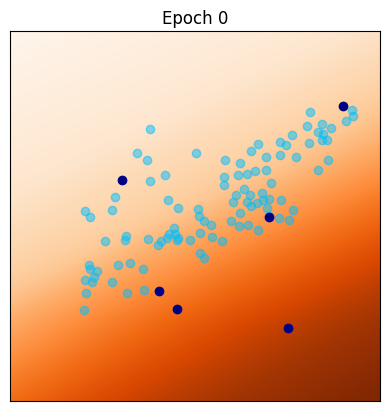

[1/100] 	Loss_D: 1.0810	Loss_G: 0.9202
[2/100] 	Loss_D: 1.0182	Loss_G: 1.0080
[3/100] 	Loss_D: 0.9553	Loss_G: 1.1172
[4/100] 	Loss_D: 0.9102	Loss_G: 1.2342
[5/100] 	Loss_D: 0.8547	Loss_G: 1.4608
[6/100] 	Loss_D: 0.7619	Loss_G: 1.4250
[7/100] 	Loss_D: 0.7863	Loss_G: 1.7120
[8/100] 	Loss_D: 0.8451	Loss_G: 1.6432
[9/100] 	Loss_D: 0.8324	Loss_G: 1.6112
[10/100] 	Loss_D: 0.8401	Loss_G: 1.3920


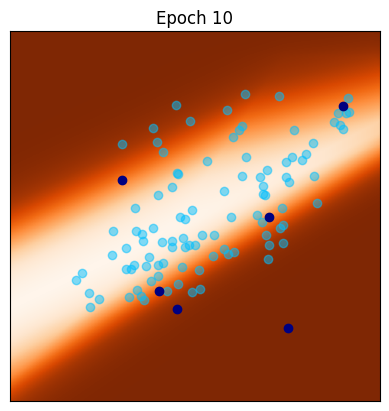

[11/100] 	Loss_D: 0.9652	Loss_G: 1.6411
[12/100] 	Loss_D: 1.0028	Loss_G: 1.3802
[13/100] 	Loss_D: 1.0215	Loss_G: 1.4168
[14/100] 	Loss_D: 1.0989	Loss_G: 1.2867
[15/100] 	Loss_D: 1.1671	Loss_G: 1.1954
[16/100] 	Loss_D: 1.0965	Loss_G: 1.0414
[17/100] 	Loss_D: 1.0839	Loss_G: 1.0865
[18/100] 	Loss_D: 1.1614	Loss_G: 1.1402
[19/100] 	Loss_D: 1.0528	Loss_G: 1.0790
[20/100] 	Loss_D: 1.0552	Loss_G: 0.9908


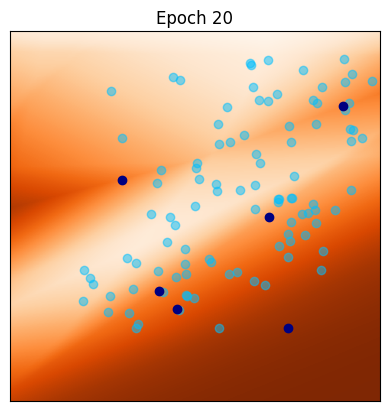

[21/100] 	Loss_D: 1.0435	Loss_G: 1.0995
[22/100] 	Loss_D: 1.0294	Loss_G: 1.0926
[23/100] 	Loss_D: 1.0857	Loss_G: 1.1498
[24/100] 	Loss_D: 1.0334	Loss_G: 1.2132
[25/100] 	Loss_D: 0.9864	Loss_G: 0.9943
[26/100] 	Loss_D: 1.0092	Loss_G: 1.2984
[27/100] 	Loss_D: 0.9142	Loss_G: 1.2385
[28/100] 	Loss_D: 1.0247	Loss_G: 1.3390
[29/100] 	Loss_D: 0.9932	Loss_G: 1.3539
[30/100] 	Loss_D: 1.0015	Loss_G: 1.5026


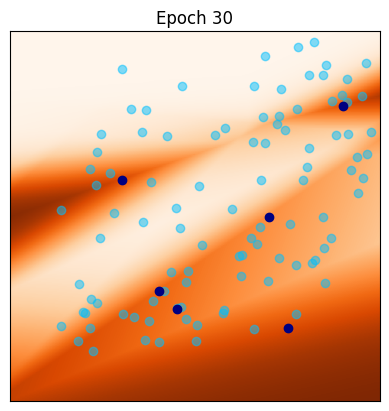

[31/100] 	Loss_D: 0.9417	Loss_G: 1.2240
[32/100] 	Loss_D: 0.9664	Loss_G: 1.8634
[33/100] 	Loss_D: 0.9260	Loss_G: 1.5736
[34/100] 	Loss_D: 0.8700	Loss_G: 1.2802
[35/100] 	Loss_D: 0.9013	Loss_G: 1.6489
[36/100] 	Loss_D: 0.8452	Loss_G: 1.4906
[37/100] 	Loss_D: 0.9523	Loss_G: 1.6416
[38/100] 	Loss_D: 0.8872	Loss_G: 1.4627
[39/100] 	Loss_D: 0.8069	Loss_G: 1.6032
[40/100] 	Loss_D: 0.8658	Loss_G: 1.8832


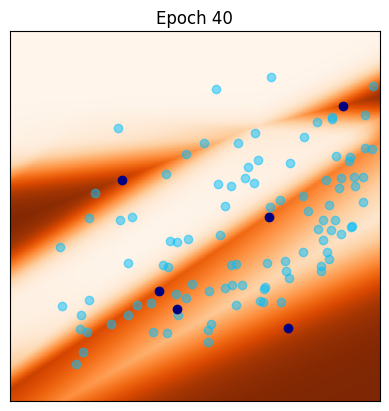

[41/100] 	Loss_D: 0.8760	Loss_G: 1.5544
[42/100] 	Loss_D: 0.8926	Loss_G: 1.5520
[43/100] 	Loss_D: 0.7453	Loss_G: 1.4655
[44/100] 	Loss_D: 0.7969	Loss_G: 1.6022
[45/100] 	Loss_D: 0.8703	Loss_G: 1.6846
[46/100] 	Loss_D: 0.8645	Loss_G: 1.9024
[47/100] 	Loss_D: 0.7855	Loss_G: 1.6318
[48/100] 	Loss_D: 0.8089	Loss_G: 1.8455
[49/100] 	Loss_D: 0.8687	Loss_G: 1.9619
[50/100] 	Loss_D: 0.8622	Loss_G: 1.7259


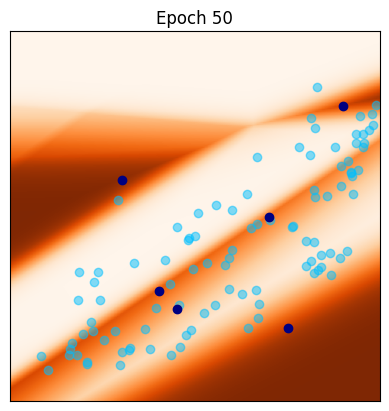

[51/100] 	Loss_D: 0.8260	Loss_G: 1.4758
[52/100] 	Loss_D: 0.7694	Loss_G: 1.2897
[53/100] 	Loss_D: 0.8633	Loss_G: 1.7079
[54/100] 	Loss_D: 0.9358	Loss_G: 1.9107
[55/100] 	Loss_D: 0.8493	Loss_G: 1.6283
[56/100] 	Loss_D: 0.8219	Loss_G: 1.5757
[57/100] 	Loss_D: 0.7703	Loss_G: 1.7549
[58/100] 	Loss_D: 0.7910	Loss_G: 1.4788
[59/100] 	Loss_D: 0.8414	Loss_G: 1.5893
[60/100] 	Loss_D: 0.7698	Loss_G: 1.4449


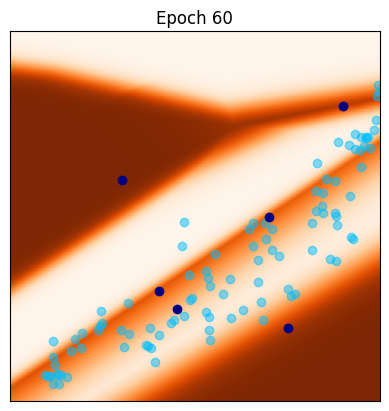

[61/100] 	Loss_D: 0.8877	Loss_G: 1.9233
[62/100] 	Loss_D: 0.7423	Loss_G: 1.4020
[63/100] 	Loss_D: 0.8229	Loss_G: 1.6102
[64/100] 	Loss_D: 0.8168	Loss_G: 1.5150
[65/100] 	Loss_D: 0.7934	Loss_G: 1.8862
[66/100] 	Loss_D: 0.7815	Loss_G: 1.4970
[67/100] 	Loss_D: 0.8125	Loss_G: 1.7335
[68/100] 	Loss_D: 0.8009	Loss_G: 1.7954
[69/100] 	Loss_D: 0.8030	Loss_G: 1.6578
[70/100] 	Loss_D: 0.8498	Loss_G: 1.7930


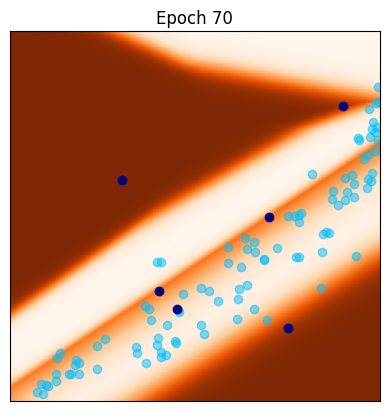

[71/100] 	Loss_D: 0.8098	Loss_G: 1.7024
[72/100] 	Loss_D: 0.7974	Loss_G: 1.5829
[73/100] 	Loss_D: 0.8090	Loss_G: 1.6809
[74/100] 	Loss_D: 0.7740	Loss_G: 1.6114
[75/100] 	Loss_D: 0.7641	Loss_G: 1.5516
[76/100] 	Loss_D: 0.8505	Loss_G: 1.6159
[77/100] 	Loss_D: 0.8052	Loss_G: 1.5086
[78/100] 	Loss_D: 0.7950	Loss_G: 1.5736
[79/100] 	Loss_D: 0.8303	Loss_G: 1.5760
[80/100] 	Loss_D: 0.7934	Loss_G: 1.6099


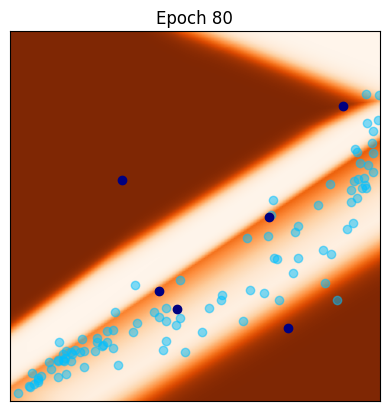

[81/100] 	Loss_D: 0.8060	Loss_G: 1.7046
[82/100] 	Loss_D: 0.7839	Loss_G: 1.1567
[83/100] 	Loss_D: 0.8110	Loss_G: 1.4987
[84/100] 	Loss_D: 0.8515	Loss_G: 1.5202
[85/100] 	Loss_D: 0.8049	Loss_G: 1.3086
[86/100] 	Loss_D: 0.8325	Loss_G: 1.8174
[87/100] 	Loss_D: 0.8339	Loss_G: 1.7931
[88/100] 	Loss_D: 0.8249	Loss_G: 1.3325
[89/100] 	Loss_D: 0.8280	Loss_G: 1.2385
[90/100] 	Loss_D: 0.8384	Loss_G: 1.6937


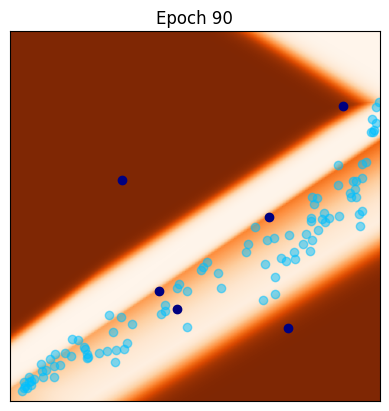

[91/100] 	Loss_D: 0.8382	Loss_G: 1.4804
[92/100] 	Loss_D: 0.8346	Loss_G: 1.2642
[93/100] 	Loss_D: 0.8133	Loss_G: 1.2611
[94/100] 	Loss_D: 0.8676	Loss_G: 1.6642
[95/100] 	Loss_D: 0.8185	Loss_G: 1.3561
[96/100] 	Loss_D: 0.8675	Loss_G: 1.4251
[97/100] 	Loss_D: 0.8083	Loss_G: 1.4620
[98/100] 	Loss_D: 0.7916	Loss_G: 1.4175
[99/100] 	Loss_D: 0.8563	Loss_G: 1.4924


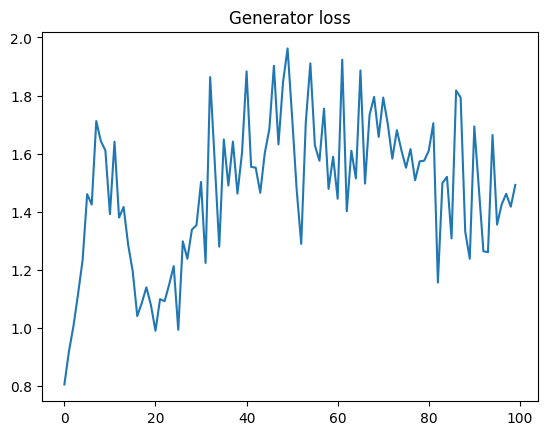

In [29]:
lr = 0.002   # learning rate for generator
lrdisc = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=100
niterG=1

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

for epoch in range(n_epochs):


    for iter in range(niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        y_real = y

        V1_real = torch.full((y_real.size(0), 1), 1.0, dtype=torch.float, device=device)

        D_real = D(y_real)
        D_fake = D(x_fake.detach())

        Dloss_real = criterion(D_real, V1_real)
        Dloss_fake = criterion(D_fake, V0)
        Dloss = Dloss_real + Dloss_fake

        Dloss.backward()
        optimD.step()

    for iter in range(niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x_fake = G(z)

        Gloss = criterion(D(x_fake), V1)

        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if epoch % iter_display == 0:
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch ' + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap='Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c='deepskyblue', alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

# Plot the evolution of the generator loss
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title('Generator loss')
plt.show()